In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import *

from pyomo.environ import *

### Comparing stochastic optimization techniques

We wish to compare solutions to scenario-based optimization problems in the context of renewable resource planning.

##### Setting: 

Hourly CF of wind $w$ is random according to some distribution $F_w: [0, 1] \to [0,1]$. Hourly load $l$ is constant. $F_w$ is not known explicitly but we can draw i.i.d. samples from $F_w$. 

We wish to select the amount of new wind to build on the system $C$ that minimizes total system cost. We have chosen units such that the levelized fixed cost of investment in new wind build is 1. The variable cost of wind is 0, and the variable cost of existing thermal generation is $k$. Thus whenever load exceeds the amount of available wind generation $C*w_i$, the system variable costs are $k * (l - C*w_i)$.

Each random sample $w_i \sim F_w$ corresponds to a "scenario". The corresponding scenario cost for a fixed value of $C$ is $k * \max \{0, l - C*w_i \}$ (k constant). The cost associated with $C$ itself is just $C$.

There are three optimization formulations that we will compare:

#### 1. Flaw-of-Averages / Naive Expected Value Program

$\min C + k * \max \{0, l - C * E[w]\}$

with finite sample approximation

$\min C + k * \max \{0, l - C * \frac{1}{n} \sum_{i=1}^{n}{w_i}\}$

#### 2. Stochastic Program

$\min C + E[ k * \max \{0, l - C * w \} ]$

with finite sample approximation

$\min C + \frac{1}{n} \sum_{i=1}^{n}{ k * \max \{0, l_i - C*w_i \}}$ 

#### 3. Robust Mini-Max Cost Program

$\min C + \sup \{ k * \max \{0, l - C*w \} : w \in support(F_w) \}$

with finite sample approximation

$\min C + \max \{ k * \max \{0, l_i - C*w_i \} : i = 1,..., n\}$

#### 4. Robust Mini-Max Regret Program

$\min C + \sup \{ regret(C; w) : w \in support(F_w) \}$

where $regret(C; w) = k * \max\{0, l - C*w\} - k * \max\{0, l - C_{opt}(w)*w\}$ is defined as the difference between $k * \max\{0, l - C*w\}$ and the optimal variable cost in the scenario associated with $w$, denoted $k * \max\{0, l - C_{opt}(w)*w\}$. This has finite sample approximation

$\min C + \max \{ regret(C, w_i) : i = 1,..., n\}$

We linearize the term in the objective $\max \{0, l - C*w_i\}$ by replacing it with an auxiliary variable $\eta_i \geq 0$ and adding a constraint $\eta_i \geq l - C*w_i$.

### 0. Collecting random sample of $w_i$

In [77]:
n = 10 # Number of samples to draw
w = 0.6*np.random.rand(n) + 0.2 # Wind CF are uniform(0.2, 0.8)

k = 3.5 # Variable cost of existing firm generation
l = 100 # MW ; constant level of load

### 1. Flaw-of-Averages / Naive Expected Value Program

In [78]:
# Construct optimization model

def naive_model(w, verbose = False):

    # Define sample average of wind CF
    w_bar = np.mean(w)

    model = ConcreteModel()

    # Variables
    model.C = Var(domain=NonNegativeReals) # Decision variable for wind build
    model.eta_bar = Var(domain=NonNegativeReals) # Auxiliary variable for variable costs

    # Parameters
    model.k = Param(initialize = k) # Define variable cost of existing firm generation
    model.l = Param(initialize = l) # Define constant load level
    model.w_bar = Param(initialize = w_bar) # Define sample average of wind CF

    # Objective
    def objective(m): # Define objective function
        return m.C + m.k*m.eta_bar

    model.obj = Objective(rule = objective, sense = minimize)

    # Constraints
    def const(m):
        return m.eta_bar >= m.l - m.C*m.w_bar

    model.const = Constraint(rule = const)


    # Solve model
    opt = SolverFactory('glpk')
    opt.solve(model)
    C_opt = model.C.value
    
    if verbose:
        print('Optimal wind build: {:.2f} MW'.format(C_opt))
    
    return C_opt
    
naive_model(w, verbose = True)

Optimal wind build: 197.16 MW


197.164283091559

#### 1.2 Deterministic Model

In [79]:
# Construct optimization model

def det_model(w, verbose = False):

    if np.iterable(w):
        print('Error: non-scalar parameter passed to deterministic model')
        return

    model = ConcreteModel()

    # Variables
    model.C = Var(domain=NonNegativeReals) # Decision variable for wind build
    model.eta = Var(domain=NonNegativeReals) # Auxiliary variable for variable costs

    # Parameters
    model.k = Param(initialize = k) # Define variable cost of existing firm generation
    model.l = Param(initialize = l) # Define constant load level
    model.w = Param(initialize = w) # Define sample average of wind CF

    # Objective
    def objective(m): # Define objective function
        return m.C + m.k*m.eta

    model.obj = Objective(rule = objective, sense = minimize)

    # Constraints
    def const(m):
        return m.eta >= m.l - m.C*m.w

    model.const = Constraint(rule = const)

    # Solve model
    opt = SolverFactory('glpk')
    opt.solve(model)
    C_opt = model.C.value
    OOFV = objective(model)()
    
    if verbose:
        print('Optimal wind build: {:.2f} MW'.format(C_opt))
    
    return C_opt, OOFV
    
det_model(w[0], verbose = True)

#for wi in np.linspace(0.0, 1.0, 101):
#    print('{:.2f}'.format(wi), det_model(wi)[0], det_model(wi)[1])

Optimal wind build: 150.32 MW


(150.323324114785, 150.323324114785)

### 2. Stochastic Program

In [80]:
def stochastic_model(w, verbose = False):
    
    # Construct optimization model
    model = ConcreteModel()

    # Sets
    model.samples = RangeSet(n) # Set to define samples

    # Variables
    model.C = Var(domain=NonNegativeReals) # Decision variable for wind build
    model.eta = Var(model.samples, domain=NonNegativeReals) # Auxiliary variables for scenario costs

    # Parameters
    model.k = Param(initialize = k) # Define variable cost of existing firm generation
    model.l = Param(initialize = l) # Define constant load level
    model.n = Param(initialize = n) # Define number of samples
    model.w = Param(model.samples, initialize = {i+1: w[i] for i in range(n)}) # Define sample average of wind CF

    # Objective
    def objective(m): # Define objective function
        return m.C + m.k*(1.0/m.n)*sum(m.eta[s] for s in model.samples)

    model.obj = Objective(rule = objective, sense = minimize)

    # Constraints
    def const(m, s):
        return m.eta[s] >= m.l - m.C*m.w[s]

    model.const = Constraint(model.samples, rule = const)


    # Solve model
    opt = SolverFactory('glpk')
    opt.solve(model)
    C_opt = model.C.value
    
    if verbose:
        print('Optimal wind build: {:.2f} MW'.format(C_opt))
    
    return C_opt
    
stochastic_model(w, verbose = True)

Optimal wind build: 150.32 MW


150.323324114785

### 3. Robust Mini-Max Cost Program

In [81]:
def robust_model(w, verbose = False):

    # Construct optimization model
    model = ConcreteModel()

    # Sets
    model.samples = RangeSet(n) # Set to define samples

    # Variables
    model.C = Var(domain=NonNegativeReals) # Decision variable for wind build
    model.eta = Var(model.samples, domain=NonNegativeReals) # Auxiliary variables for scenario costs
    model.zeta = Var(domain = NonNegativeReals) # Auxiliary variable for maximum of scenario costs

    # Parameters
    model.k = Param(initialize = k) # Define variable cost of existing firm generation
    model.l = Param(initialize = l) # Define constant load level
    model.n = Param(initialize = n) # Define number of samples
    model.w = Param(model.samples, initialize = {i+1: w[i] for i in range(n)}) # Define sample average of wind CF

    # Objective
    def objective(m): # Define objective function
        return m.C + m.k*m.zeta

    model.obj = Objective(rule = objective, sense = minimize)

    # Constraints
    def const(m, s):
        return m.eta[s] >= m.l - m.C*m.w[s]

    model.const = Constraint(model.samples, rule = const)

    def aux_const(m, s):
        return m.zeta >= m.eta[s]

    model.aux_const = Constraint(model.samples, rule = aux_const)


    # Solve model
    opt = SolverFactory('glpk')
    opt.solve(model)
    C_opt = model.C.value
    
    if verbose:
        print('Optimal wind build: {:.2f} MW'.format(C_opt))
    
    return C_opt

robust_model(w, verbose = True)

Optimal wind build: 0.00 MW


0.0

### 4. Robust Mini-Max Regret Program

In [82]:
def regret_model(w, verbose = False):

    # Get deterministic scenario costs
    C_opts = np.zeros(len(w))
    for i, wi in enumerate(w):
        C_opts[i] = det_model(wi)[0]
    
    # Construct optimization model
    model = ConcreteModel()

    # Sets
    model.samples = RangeSet(n) # Set to define samples

    # Variables
    model.C = Var(domain=NonNegativeReals) # Decision variable for wind build
    model.eta = Var(model.samples, domain=NonNegativeReals) # Auxiliary variables for scenario costs
    model.zeta = Var(domain = NonNegativeReals) # Auxiliary variable for maximum of scenario costs

    # Parameters
    model.k = Param(initialize = k) # Define variable cost of existing firm generation
    model.l = Param(initialize = l) # Define constant load level
    model.n = Param(initialize = n) # Define number of samples
    model.w = Param(model.samples, initialize = {i+1: w[i] for i in range(n)}) # Define sample average of wind CF
    model.C_opts = Param(model.samples, initialize = {i+1: C_opts[i] for i in range(n)}) # Define scenario solutions
    
    # Objective
    def objective(m): # Define objective function
        return m.C + m.k*m.zeta

    model.obj = Objective(rule = objective, sense = minimize)

    # Constraints
    def const(m, s):
        return m.eta[s] >= (m.l - m.C*m.w[s]) - (m.l - m.C_opts[s]*m.w[s]) # Regret

    model.const = Constraint(model.samples, rule = const)

    def aux_const(m, s):
        return m.zeta >= m.eta[s]

    model.aux_const = Constraint(model.samples, rule = aux_const)


    # Solve model
    opt = SolverFactory('glpk')
    opt.solve(model)
    C_opt = model.C.value
    
    if verbose:
        print('Optimal wind build: {:.2f} MW'.format(C_opt))
    
    return C_opt

regret_model(w, verbose = True)

Optimal wind build: 346.19 MW


346.188575788131

In [83]:
M = 500 # Number of trials to run

naive_arr = np.zeros(M)
stochastic_arr = np.zeros(M)
robust_arr = np.zeros(M)
regret_arr = np.zeros(M)

for m in range(M):
    
    # Define random vector of wind CFs
    w = 0.6*np.random.rand(n) + 0.2 # Wind CF are uniform(0.2, 0.8)
    
    # Run models
    naive_arr[m] = naive_model(w)
    stochastic_arr[m] = stochastic_model(w)
    robust_arr[m] = robust_model(w)
    regret_arr[m] = regret_model(w)

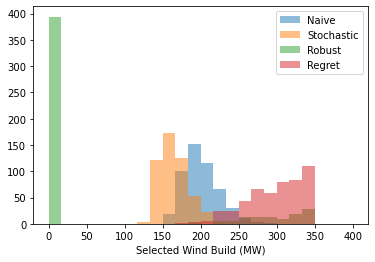

In [88]:
plt.hist(naive_arr, bins = np.linspace(0, 400, 25), alpha = 0.5, label = 'Naive')
plt.hist(stochastic_arr, bins = np.linspace(0, 400, 25), alpha = 0.5, label = 'Stochastic')
plt.hist(robust_arr, bins = np.linspace(0, 400, 25), alpha = 0.5, label = 'Robust')
plt.hist(regret_arr, bins = np.linspace(0, 400, 25), alpha = 0.5, label = 'Regret')

plt.legend()
plt.xlabel('Selected Wind Build (MW)')
plt.show()

In [102]:
def OOS_variable_costs(C):
    S = 100
    np.random.seed(4)
    w_oos = np.random.rand(S)
    costs_oos = k*np.max(np.array([np.zeros(S), l - C*w_oos]), axis = 0)
    return costs_oos

In [104]:
naive_costs = np.zeros(M)
stochastic_costs = np.zeros(M)
robust_costs = np.zeros(M)
regret_costs = np.zeros(M)

for m in range(M):
    
    naive_costs[m] = np.mean(OOS_variable_costs(naive_arr[m]))
    stochastic_costs[m] = np.mean(OOS_variable_costs(stochastic_arr[m]))
    robust_costs[m] = np.mean(OOS_variable_costs(robust_arr[m]))
    regret_costs[m] = np.mean(OOS_variable_costs(regret_arr[m]))

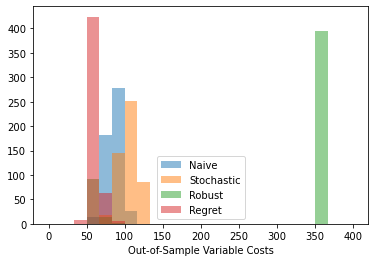

In [106]:
plt.hist(naive_costs, bins = np.linspace(0, 400, 25), alpha = 0.5, label = 'Naive')
plt.hist(stochastic_costs, bins = np.linspace(0, 400, 25), alpha = 0.5, label = 'Stochastic')
plt.hist(robust_costs, bins = np.linspace(0, 400, 25), alpha = 0.5, label = 'Robust')
plt.hist(regret_costs, bins = np.linspace(0, 400, 25), alpha = 0.5, label = 'Regret')

plt.legend()
plt.xlabel('Out-of-Sample Variable Costs')
plt.show()